<h2> CNN Auto Encoder PyTorch </h2>

In [1]:
import torch 
import torch.nn as nn 
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchsummary import summary
torch.cuda.get_device_name(0)


'NVIDIA GeForce RTX 2060'

<h3> Dataset </h3>

In [17]:
transform = transforms.ToTensor() # creates [0, 1] values

'''transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)) # creates [-1, 1] values
])''' 


mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=128,
                                          shuffle=True)

In [18]:
dataiter = iter(data_loader)
images, labels = dataiter.next()
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


<h3> Model </h3>

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        # N, 1, 28, 28
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # N, 64, 1, 1
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid() # N, 1, 28, 28
            # [-1, 1] -> nn.Tanh
            # [0,1] -> nn.Sigmoid
        )


    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# nn.NaxPool2d -> nn.MaxUnpool2d 

In [3]:
cnn_ae = AutoEncoder()
summary(cnn_ae.cuda(), (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 1, 1]            --
|    └─Conv2d: 2-1                       [-1, 16, 14, 14]          160
|    └─ReLU: 2-2                         [-1, 16, 14, 14]          --
|    └─Conv2d: 2-3                       [-1, 32, 7, 7]            4,640
|    └─ReLU: 2-4                         [-1, 32, 7, 7]            --
|    └─Conv2d: 2-5                       [-1, 64, 1, 1]            100,416
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-6              [-1, 32, 7, 7]            100,384
|    └─ReLU: 2-7                         [-1, 32, 7, 7]            --
|    └─ConvTranspose2d: 2-8              [-1, 16, 14, 14]          4,624
|    └─ReLU: 2-9                         [-1, 16, 14, 14]          --
|    └─ConvTranspose2d: 2-10             [-1, 1, 28, 28]           145
|    └─Sigmoid: 2-11                     [-1, 1, 28, 28]           

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 1, 1]            --
|    └─Conv2d: 2-1                       [-1, 16, 14, 14]          160
|    └─ReLU: 2-2                         [-1, 16, 14, 14]          --
|    └─Conv2d: 2-3                       [-1, 32, 7, 7]            4,640
|    └─ReLU: 2-4                         [-1, 32, 7, 7]            --
|    └─Conv2d: 2-5                       [-1, 64, 1, 1]            100,416
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-6              [-1, 32, 7, 7]            100,384
|    └─ReLU: 2-7                         [-1, 32, 7, 7]            --
|    └─ConvTranspose2d: 2-8              [-1, 16, 14, 14]          4,624
|    └─ReLU: 2-9                         [-1, 16, 14, 14]          --
|    └─ConvTranspose2d: 2-10             [-1, 1, 28, 28]           145
|    └─Sigmoid: 2-11                     [-1, 1, 28, 28]           

<h3> Instantiate </h3>

In [29]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"using {device}")

model = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

using cuda


<h3> Train </h3>

In [21]:
import time
num_epochs = 30
outputs = []

start_time_sec = time.time()

for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img = img.to(device)
        predict = model(img)
        loss = criterion(predict, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, predict))

end_time_sec       = time.time()
total_time_sec     = end_time_sec - start_time_sec
time_per_epoch_sec = total_time_sec / num_epochs
total_time_sec = total_time_sec / 60
time_per_epoch_sec = time_per_epoch_sec / 60

print()
print('Time total:     %5.2f min' % (total_time_sec))
print('Time per epoch: %5.2f min' % (time_per_epoch_sec))

Epoch:1, Loss:0.0136
Epoch:2, Loss:0.0077
Epoch:3, Loss:0.0052
Epoch:4, Loss:0.0041
Epoch:5, Loss:0.0036
Epoch:6, Loss:0.0036
Epoch:7, Loss:0.0032
Epoch:8, Loss:0.0031
Epoch:9, Loss:0.0028
Epoch:10, Loss:0.0027
Epoch:11, Loss:0.0029
Epoch:12, Loss:0.0029
Epoch:13, Loss:0.0029
Epoch:14, Loss:0.0026
Epoch:15, Loss:0.0025
Epoch:16, Loss:0.0025
Epoch:17, Loss:0.0025
Epoch:18, Loss:0.0029
Epoch:19, Loss:0.0023
Epoch:20, Loss:0.0026
Epoch:21, Loss:0.0025
Epoch:22, Loss:0.0025
Epoch:23, Loss:0.0026
Epoch:24, Loss:0.0024
Epoch:25, Loss:0.0026
Epoch:26, Loss:0.0024
Epoch:27, Loss:0.0026
Epoch:28, Loss:0.0024
Epoch:29, Loss:0.0024
Epoch:30, Loss:0.0023

Time total:      2.83 min
Time per epoch:  0.09 min


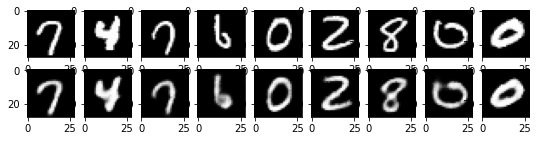

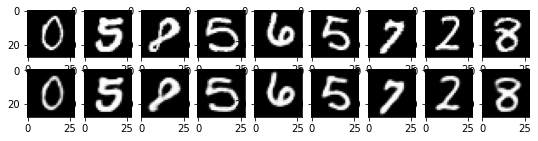

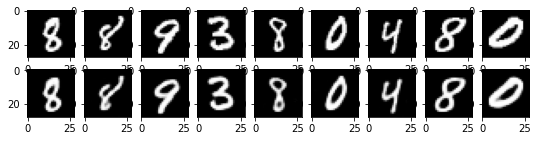

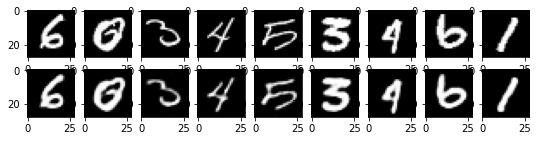

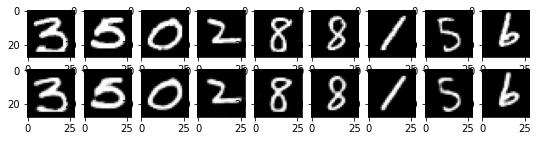

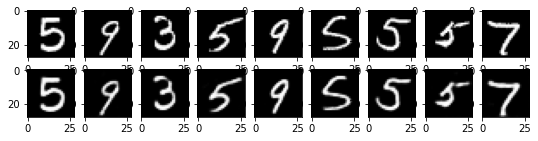

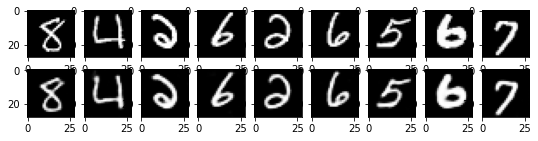

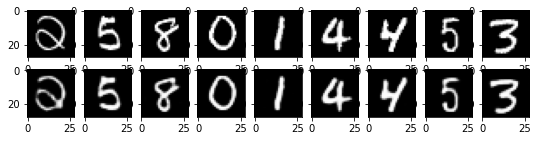

In [28]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()

    imgs = outputs[k][1]
    predict = outputs[k][2]

    # Had to bring back to CPU for further operations
    imgs = imgs.to('cpu')
    predict = predict.to('cpu')
    imgs = imgs.detach().numpy()
    predict = predict.detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(predict):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])